# Examining geospatial properties of house prices in St Albans 

In this notebook, we use data analysis and visualisation to examine reasons for house prices distributions seen in St Albans. We've concentrated on St Albans as it is the first postcode area (AL) in an alphabetical list of postcode areas in England and Wales. 

We attempt to answer the question: "These two houses have the same floor area, yet one is more expensive; is it due to its location in town"?

To do so, we show a procedure to create "*added-value regions*": that is, distinct regions of St Albans clustered by their location and their *added-value*; that is, their residual compared to a linear-regression relating sold price to floor area (i.e high *added-value* equals a price in excess of that predicted by the average price per square foot of floor area for the whole of the St Albans area).  

This notebook is composed of different sections: 

1. Firstly, we perform exploratory data analyis on the price and feature distributions.
2. The dataset created in the previous notebook contains sold property prices over nearly 30 years, so we adjust for the effects of house price inflation. By doing so, we will be able to use the full 30 year dataset.
3. We then use linear regression to create a simple model for the whole St Albans region relating the inflation-adjusted sold price to the total floor area of the property. Since we find log-normal distributions, the linear regression will use the natural log of both the price and the total floor area. 
4. To create the different *added-value regions*, we examine the residuals to the linear regression model and relate it to the geospatial distribution. As stated above, we have termed this residual as *house added-value*. Maps generated use folium and geojson. We cluster by these residual values and location (using DBSCAN) by using the average of "unit" (i.e. full) postcodes (which typically contain 15 properties). The clustering creates approxiamtely 20 regions. 
5. We show the 20 regions of St Albans on a map and examine the correlation between different features of the properties (such as type of house, number of habitable rooms and age of the property) within the cluster and the average *added-value*. 
6. We then show how Random Forest Regression models are impoved by incuding these region labels. We see an increase in the r2 for inflation adjusted prices for houses in the AL1 postcode sector from 0.74 to 0.8 by including their *added-value region as a feature. 


There's a lot to get through, let's go!


# Exploratory Data Analysis (EDA)

In this section, we will examine the properties of the merged data set for sold house prices in St Albans, UK. 



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

In [2]:
df = pd.read_csv('./merged_datasets.csv')

In [3]:
#let's look at the columns in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47911 entries, 0 to 47910
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     47911 non-null  int64  
 1   Transaction unique identifier  47911 non-null  object 
 2   Price                          47911 non-null  int64  
 3   Date of Transfer               47911 non-null  object 
 4   POSTCODE                       47911 non-null  object 
 5   property type                  47911 non-null  object 
 6   Old/New                        47911 non-null  object 
 7   Duration                       47911 non-null  object 
 8   SAON                           7001 non-null   object 
 9   PAON                           47908 non-null  object 
 10  street                         47892 non-null  object 
 11  Locality,                      26730 non-null  object 
 12  Town/City                      47911 non-null 

We have dataset of 34 features. We are missing several number of habitable rooms entries, but we have a total floor area for each record. 

Let's have a look at the price distribution. 

# Data Analysis of the Price Distribution

count    4.791100e+04
mean     3.658676e+05
std      3.793592e+05
min      2.000000e+02
25%      1.750000e+05
50%      2.922500e+05
75%      4.810000e+05
max      5.056831e+07
Name: Price, dtype: float64
Skewness : 53.424610
Kurtosis : 6575.732730


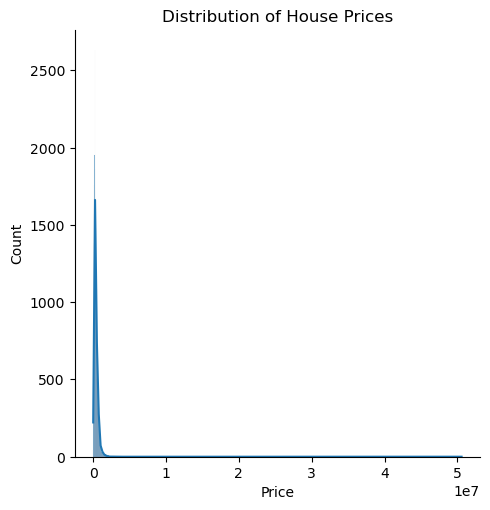

<Figure size 640x480 with 0 Axes>

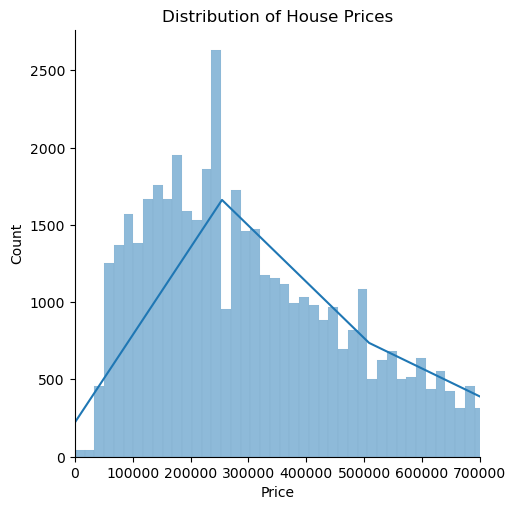

In [4]:
print(df['Price'].describe())
print("Skewness : %f" % df['Price'].skew())
print("Kurtosis : %f" % df['Price'].kurt())

sns.displot(df['Price'], kde=True)
plt.title("Distribution of House Prices")
plt.show()
plt.clf()

sns.displot(df['Price'], kde=True)
plt.title("Distribution of House Prices")
plt.xlim(0, df['Price'].quantile(.9))

plt.show()

As we can see, there are some very high prices, which distort the histogram. Zooming in, we see that the Price distribution is not normal. The Skew and Kurtosis are very large - demonstrating this is not a Gaussian! 

We will instead compute the log distribution of prices, which we'll use in our linear regression model. 

In [5]:
df.loc[:,'LogPrice'] = np.log(df['Price'])
print("Skewness : %f" % df['LogPrice'].skew())
print("Kurtosis : %f" % df['LogPrice'].kurt())

Skewness : -0.376478
Kurtosis : 1.016991


The Skew and Kurtosis are much reduced. Let's look at the price over time by computing a rolling average over 90 days (approximately 3 months). We can see it increases dramatically over time. 

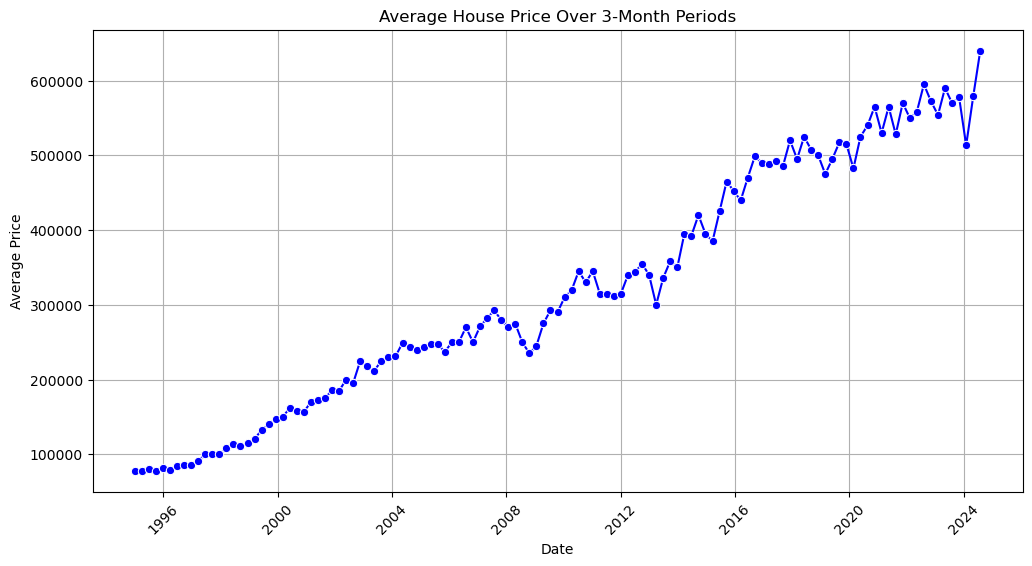

In [6]:
# convert Date of Transfer to datetime object

df['Date of Transfer'] = pd.to_datetime(df['Date of Transfer'])

df.set_index('Date of Transfer', inplace=True)
df = df.sort_index()
df_avg_price = df['Price'].resample('90D').median()
df_avg_price = df_avg_price.reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_price, x='Date of Transfer', y='Price', marker='o', color='blue')
plt.title("Average House Price Over 3-Month Periods")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can look at the distribution of prices around the median value over a three month rolling window. We use the median as not to get distorted by very high sales. We see in the cell below that the standard deviation also increases, inline with the price (albeit with a big outlier in 2017). So let's look at the distribution around the median value, scaled by the house price inflation, and see if that is also normally distributed.

# Computing the distribution around the median house price value (over a 3 month rolling window)

<Figure size 640x480 with 0 Axes>

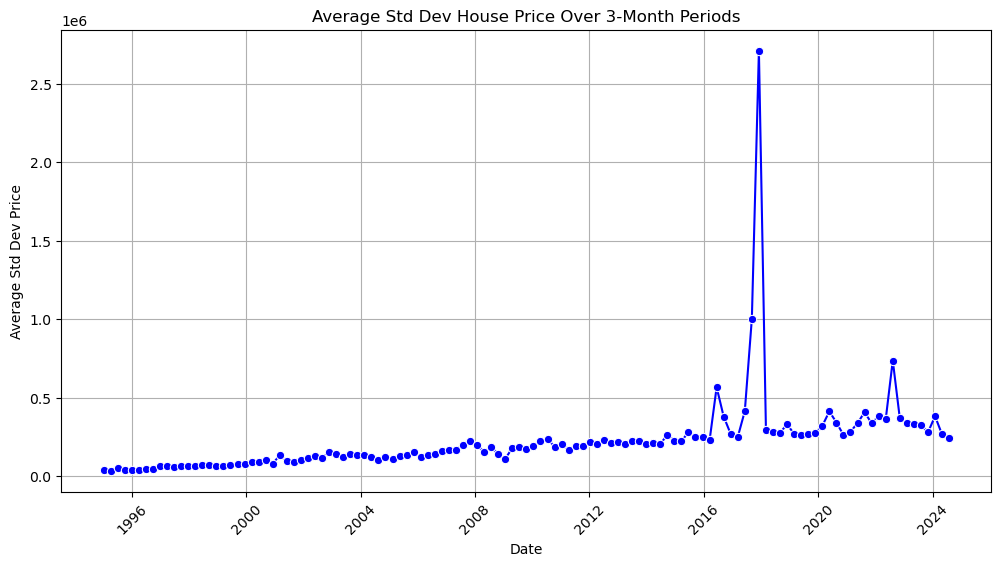

Correlation between median Price and standard deviation over a 3 month rolling window : 0.500871


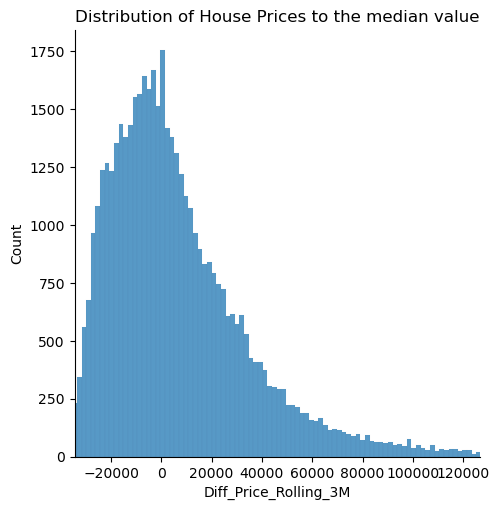

Skewness Price Difference to Rolling Median : 43.465348
Kurtosis Price Difference to Rolling Median : 4918.746346
Skewness Log Price Difference to Rolling Median: -1.103705
Kurtosis Log Price Difference to Rolling Median : 22.443879


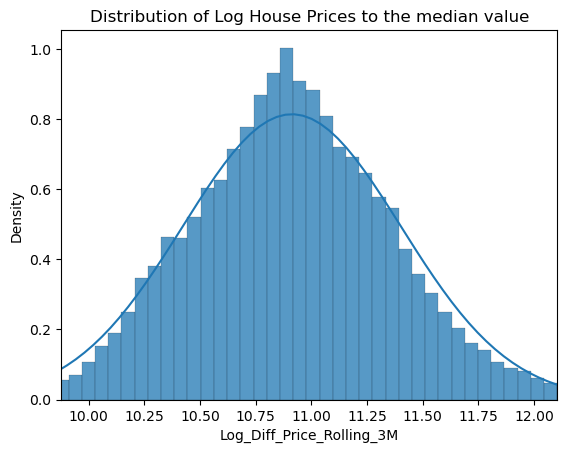

<Figure size 640x480 with 0 Axes>

In [7]:
plt.clf()
df_avg_std = df['Price'].resample('90D').std()
df_avg_std = df_avg_std.reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_std, x='Date of Transfer', y='Price', marker='o', color='blue')
plt.title("Average Std Dev House Price Over 3-Month Periods")
plt.xlabel("Date")
plt.ylabel("Average Std Dev Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
# calculate correlation between price and standard deviation

print("Correlation between median Price and standard deviation over a 3 month rolling window : %f" % df_avg_price['Price'].corr(df_avg_std['Price'])) 

# Calculate 3-month rolling median of Price and compute difference, scaled by the Price inflation (with the first record = 0)

df['Price_Rolling_3M'] = df['Price'].rolling(window='90D').median()
df['Inflation_factor'] = df['Price_Rolling_3M'] / df['Price_Rolling_3M'].iloc[0]
df['Diff_Price_Rolling_3M'] = (df['Price'] - df['Price_Rolling_3M']) / df['Inflation_factor']

sns.displot(df['Diff_Price_Rolling_3M'])
plt.title("Distribution of House Prices to the median value")
plt.xlim(df['Diff_Price_Rolling_3M'].quantile(.01), df['Diff_Price_Rolling_3M'].quantile(.99))
plt.show()
plt.clf() 

print("Skewness Price Difference to Rolling Median : %f" % df['Diff_Price_Rolling_3M'].skew())
print("Kurtosis Price Difference to Rolling Median : %f" % df['Diff_Price_Rolling_3M'].kurt())

df['Diff_Price_Rolling_3M'] = df['Diff_Price_Rolling_3M'] - df['Diff_Price_Rolling_3M'].min() +0.1 # shift so only +ve values 
df['Log_Diff_Price_Rolling_3M'] = np.log(df['Diff_Price_Rolling_3M']) # only +ve Prices 

print("Skewness Log Price Difference to Rolling Median: %f" % df['Log_Diff_Price_Rolling_3M'].skew(numeric_only=True))
print("Kurtosis Log Price Difference to Rolling Median : %f" % df['Log_Diff_Price_Rolling_3M'].kurt(numeric_only=True))

ax = sns.histplot(df['Log_Diff_Price_Rolling_3M'], bins=300, stat='density')

mu, std = stats.norm.fit(df['Log_Diff_Price_Rolling_3M'])
xx = np.linspace(*ax.get_xlim(),500)
ax.plot(xx, stats.norm.pdf(xx, mu, std))
plt.title("Distribution of Log House Prices to the median value")
plt.xlim(df['Log_Diff_Price_Rolling_3M'].quantile(.01), df['Log_Diff_Price_Rolling_3M'].quantile(.99))
plt.show()
plt.clf() 


 

So we now have computed the distributions of prices around the median, adjusted for house price inflation. When we take the log of this distribution, we appear to have a Gaussian distribution. However, the kurtosis value is very high, despite the distribution appearing "normal". High kurtosis is due to the distribution having fatter tails and outliers compared to the normal distribution. We can see this below in the QQ plot, which should be a straight line if normally distributed.  

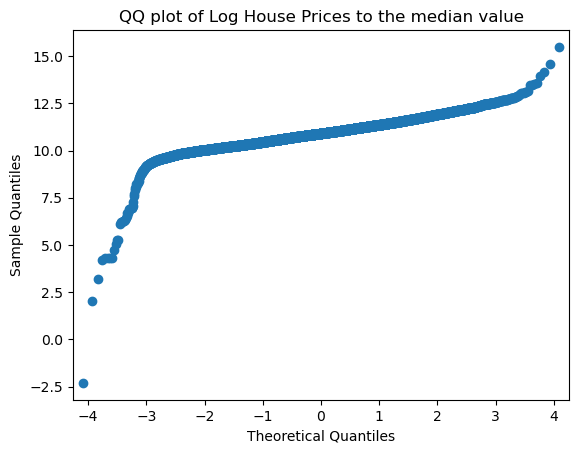

<Figure size 640x480 with 0 Axes>

In [8]:
import statsmodels.api as sm
sm.qqplot(df['Log_Diff_Price_Rolling_3M'])
plt.title("QQ plot of Log House Prices to the median value")
plt.show()
plt.clf()

Let's find out how many records we can classify as outliers and drop - which will define as when the QQ plot starts to deviate from linearity. We define this as < 9.0 and > 12.0


NUMBER OF OUTLIERS LOW END 55
NUMBER OF OUTLIERS HIGH END 83


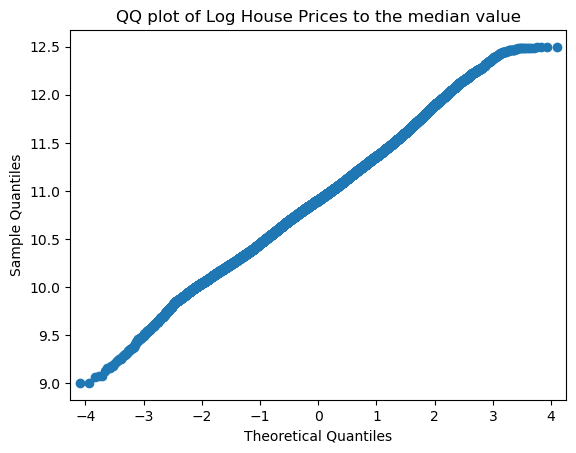

<Figure size 640x480 with 0 Axes>

In [9]:
print("NUMBER OF OUTLIERS LOW END", len(df.loc[df['Log_Diff_Price_Rolling_3M'] < 9.0]))
print("NUMBER OF OUTLIERS HIGH END", len(df.loc[df['Log_Diff_Price_Rolling_3M'] > 12.5]))

df_filtered = df[(df['Log_Diff_Price_Rolling_3M'] > 9.0) & (df['Log_Diff_Price_Rolling_3M'] < 12.5)]
sm.qqplot(df_filtered['Log_Diff_Price_Rolling_3M'])
plt.title("QQ plot of Log House Prices to the median value")
plt.show()
plt.clf()
df = df_filtered

So now we have our target distribution - an inflation adjusted log-normal "Price" distribution. 

# Handling missing values

In [10]:
nan_counts = df_filtered.isnull().sum()
print("Number of NaN values per column:\n", nan_counts)

Number of NaN values per column:
 Unnamed: 0                           0
Transaction unique identifier        0
Price                                0
POSTCODE                             0
property type                        0
Old/New                              0
Duration                             0
SAON                             40787
PAON                                 3
street                              16
Locality,                        21113
Town/City                            0
District                             0
County                               0
PPDCategory Type                     0
Record Status                        0
NUMBERS_1                            0
NUMBERS_SAON                         0
NUMBERS_PAON                         0
ADDRESS                              0
TOTAL_FLOOR_AREA                     0
NUMBER_HABITABLE_ROOMS            3350
NUMBER_HEATED_ROOMS               3350
ADDRESS1                             0
ADDRESS2                      

We have missing values in NUMBER_HABITABLE_ROOMS, NUMBER_HEATED_ROOMS and CONSTRUCTION_AGE_BAND. The other columns with NaNs are address related and can be ignored. Their number is small compared to the overall number of records. We'll only concentrate on NUMBER_HABITIABLE_ROOMS. 

The missing values for NUMBER_HABITABLE_ROOMS we will impute as the mean for that floor area, binned to the nearest 10%. 

Note that NUMBER_HABITIABLE_ROOMS and NUMBER_HEATED_ROOMS are floats - they should be int, so we will convert them after imputing. 

We also need to check if we have properties with zero TOTAL_FLOOR_AREA or zero NUMBER_HABITABLE_ROOMS - both are impossible and need to be handled. 

CONSTRUCTION_AGE_BAND is an object - we'll examine that and turn it into a representative property age later. 

In [11]:
zero_area_rows = df_filtered[df_filtered['TOTAL_FLOOR_AREA'] == 0]
print("Number of Rows with TOTAL_FLOOR_AREA equal to zero:\n", len(zero_area_rows))

zero_area_floor = df_filtered[df_filtered['NUMBER_HABITABLE_ROOMS'] < 1]
print("Number of Rows with NUMBER_HABITABLE_ROOMS equal to zero:\n", len(zero_area_floor))

zero_area_rows = df_filtered[(df_filtered['TOTAL_FLOOR_AREA'] == 0) & (df_filtered['NUMBER_HABITABLE_ROOMS'].isnull())]
print("Number of Rows with TOTAL_FLOOR_AREA equal to zero and NUMBER_HABITABLE_ROOMS equal to NaN :\n", len(zero_area_rows))

Number of Rows with TOTAL_FLOOR_AREA equal to zero:
 8
Number of Rows with NUMBER_HABITABLE_ROOMS equal to zero:
 0
Number of Rows with TOTAL_FLOOR_AREA equal to zero and NUMBER_HABITABLE_ROOMS equal to NaN :
 8


The number of properties with zero TOTAL_FLOOR_AREA is 8 - but these also have NaN for the  NUMBER_HABITABLE_ROOMS. 

8 is such a small number compared to the whole data set, it will be easier to drop these properties. 

There are no properties with zero NUMBER_HABITIABLE_ROOMS, so we can ignore this. 

In [12]:
df_filtered = df_filtered.drop(
    df_filtered[(df_filtered['NUMBER_HABITABLE_ROOMS'].isna()) & (df_filtered['TOTAL_FLOOR_AREA'] == 0)].index
)

percentage_range = 0.10

# Create a bin for TOTAL_FLOOR_AREA within the percentage range
df_filtered['FLOOR_AREA_BIN'] = (df_filtered['TOTAL_FLOOR_AREA'] // (df_filtered['TOTAL_FLOOR_AREA'].mean() * percentage_range)).astype(int)

# Store the original NUM_OF_ROOMS values to compare after imputation - can be commented out
df_filtered['NUMBER_HABITABLE_ROOMS_Original'] = df_filtered['NUMBER_HABITABLE_ROOMS']

# Group by both 'property_type' and 'FLOOR_AREA_BIN' to compute mean within each group, and impute missing values
df_filtered['NUMBER_HABITABLE_ROOMS'] = df_filtered.groupby(['property type', 'FLOOR_AREA_BIN'])['NUMBER_HABITABLE_ROOMS'] \
                                   .transform(lambda x: x.fillna(x.mean()))

# Drop column 'FLOOR_AREA_BIN', could reuse if wanted to do the same for NUMBER_HEATED_ROOMS
df_filtered.drop(columns=['FLOOR_AREA_BIN'], inplace=True)

# Identify rows where NUM_OF_ROOMS was imputed (i.e., values changed)
changed_rows = df_filtered[df_filtered['NUMBER_HABITABLE_ROOMS_Original'] != df_filtered['NUMBER_HABITABLE_ROOMS']]

#df_filtered['NUMBER_HABITABLE_ROOMS'] = df_filtered['NUMBER_HABITABLE_ROOMS'].astype(int)

# Display changed rows
print("Rows with imputed NUM_OF_ROOMS values:\n", changed_rows[['property type', 'TOTAL_FLOOR_AREA', 'NUMBER_HABITABLE_ROOMS_Original', 'NUMBER_HABITABLE_ROOMS']])

# drop the 'NUM_OF_ROOMS_Original', no longer needed
df_filtered.drop(columns=['NUMBER_HABITABLE_ROOMS_Original'], inplace=True)



Rows with imputed NUM_OF_ROOMS values:
                  property type  TOTAL_FLOOR_AREA  \
Date of Transfer                                   
1995-03-24                   D               169   
1995-03-24                   D               170   
1995-05-01                   F                30   
1995-06-23                   S               167   
1995-08-11                   S               162   
...                        ...               ...   
2024-07-10                   F                58   
2024-07-15                   T               198   
2024-07-15                   S               109   
2024-07-19                   T               148   
2024-08-08                   F                66   

                  NUMBER_HABITABLE_ROOMS_Original  NUMBER_HABITABLE_ROOMS  
Date of Transfer                                                           
1995-03-24                                    NaN                7.535211  
1995-03-24                                    NaN      

In [13]:
# check whether all NaNs have now been allocatd: 
non_finite_rows = df_filtered[df_filtered['NUMBER_HABITABLE_ROOMS'].isna()]

# Display the rows with non-finite values
print("NUMBER STILL NaN: ", len(non_finite_rows))

df_filtered = df_filtered.dropna(subset=['NUMBER_HABITABLE_ROOMS'])

df_filtered['NUMBER_HABITABLE_ROOMS'] = df_filtered['NUMBER_HABITABLE_ROOMS'].astype(int)

NUMBER STILL NaN:  5


One feature we can change to numeric is "CONSTRUCTION_AGE_BAND". We'll convert this by turning it in "PROPERTY_AGE", and we'll use the middle of the band to compute the age. 

In [14]:
from datetime import datetime

# Assuming your dataframe is called 'df'
current_year = datetime.now().year

def calculate_property_age(construction_band):
    if pd.isna(construction_band) or "NO DATA!" in construction_band:
        return None  
        
    # Handle the special case 'before 1900'
  
    if "before 1900" in construction_band:
        return current_year - 1900

    # Extract year range if available
    year_range = construction_band.split(": ")[-1]
    if "-" in year_range:
        start_year = int(year_range.split("-")[0])
    else:
        start_year = current_year  # Default if no range is found

    # Calculate property age
    return current_year - start_year

# Apply the function to create a new column 'PROPERTY_AGE'
df_filtered['PROPERTY_AGE'] = df_filtered['CONSTRUCTION_AGE_BAND'].apply(calculate_property_age)

# Display the updated dataframe
print(df_filtered[['CONSTRUCTION_AGE_BAND', 'PROPERTY_AGE']].head())

                         CONSTRUCTION_AGE_BAND  PROPERTY_AGE
Date of Transfer                                            
1995-01-04        England and Wales: 1983-1990          41.0
1995-01-05        England and Wales: 1991-1995          33.0
1995-01-05        England and Wales: 1950-1966          74.0
1995-01-06        England and Wales: 1996-2002          28.0
1995-01-06        England and Wales: 1983-1990          41.0


# Exploring Features 

We can look at the distribution of features. Lets first look at total floor area. We see the distribution is log-normal distributed, so let's create a new column called "Log_TOTAL_FLOOR_AREA". 

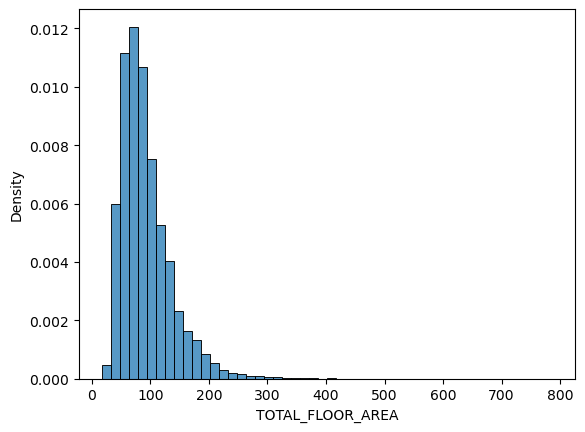

0


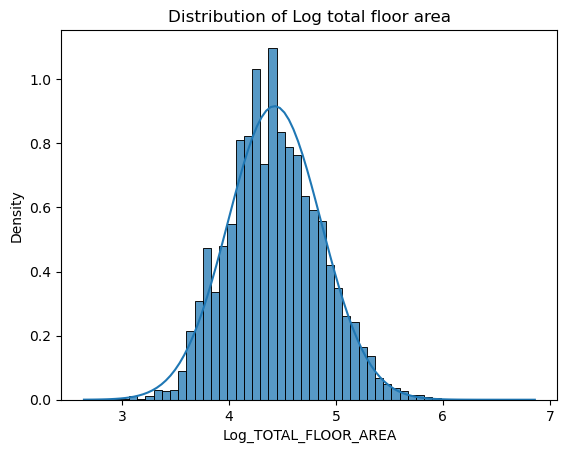

<Figure size 640x480 with 0 Axes>

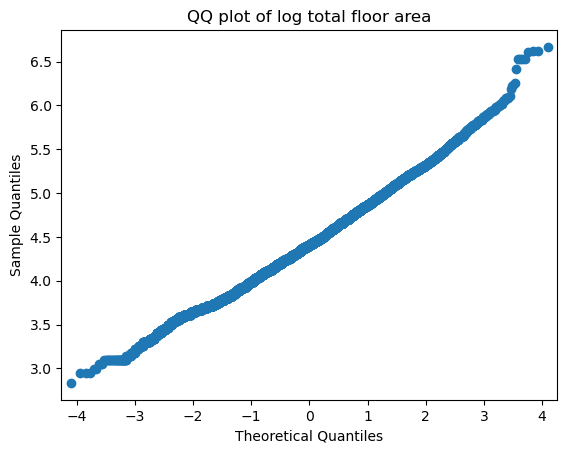

<Figure size 640x480 with 0 Axes>

In [15]:

ax = sns.histplot(df_filtered['TOTAL_FLOOR_AREA'], bins=50, stat='density')
plt.show()

# looks like a log-normal distribution. First remove any values that have zero floor area - checking how many have zero.

print((df_filtered['TOTAL_FLOOR_AREA'].values == 0).sum())

df_filtered = df_filtered[(df_filtered['TOTAL_FLOOR_AREA'] > 0)] # quick check, in case our "handling missing data" didn't work.
df_filtered.loc[:, 'Log_TOTAL_FLOOR_AREA']=np.log(df_filtered['TOTAL_FLOOR_AREA'])

# Let's have a look at the log total floor area distribution: 

ax = sns.histplot(df_filtered['Log_TOTAL_FLOOR_AREA'], bins=50, stat='density')

mu, std = stats.norm.fit(df_filtered['Log_TOTAL_FLOOR_AREA'])
xx = np.linspace(*ax.get_xlim(),100)
ax.plot(xx, stats.norm.pdf(xx, mu, std))
plt.title("Distribution of Log total floor area")

plt.show()
plt.clf() 

# lets check with a QQ plot

sm.qqplot(df_filtered['Log_TOTAL_FLOOR_AREA'])
plt.title("QQ plot of log total floor area")
plt.show()
plt.clf()


The total floor area is log-normal distributed, as shown by the linear behaviour in the QQ plot above. 
Lets have a look at all the other remaining numerical data types: 

lets look at all numeric columns

In [16]:
list(set(df_filtered.dtypes.tolist()))

[dtype('int64'), dtype('O'), dtype('float64')]

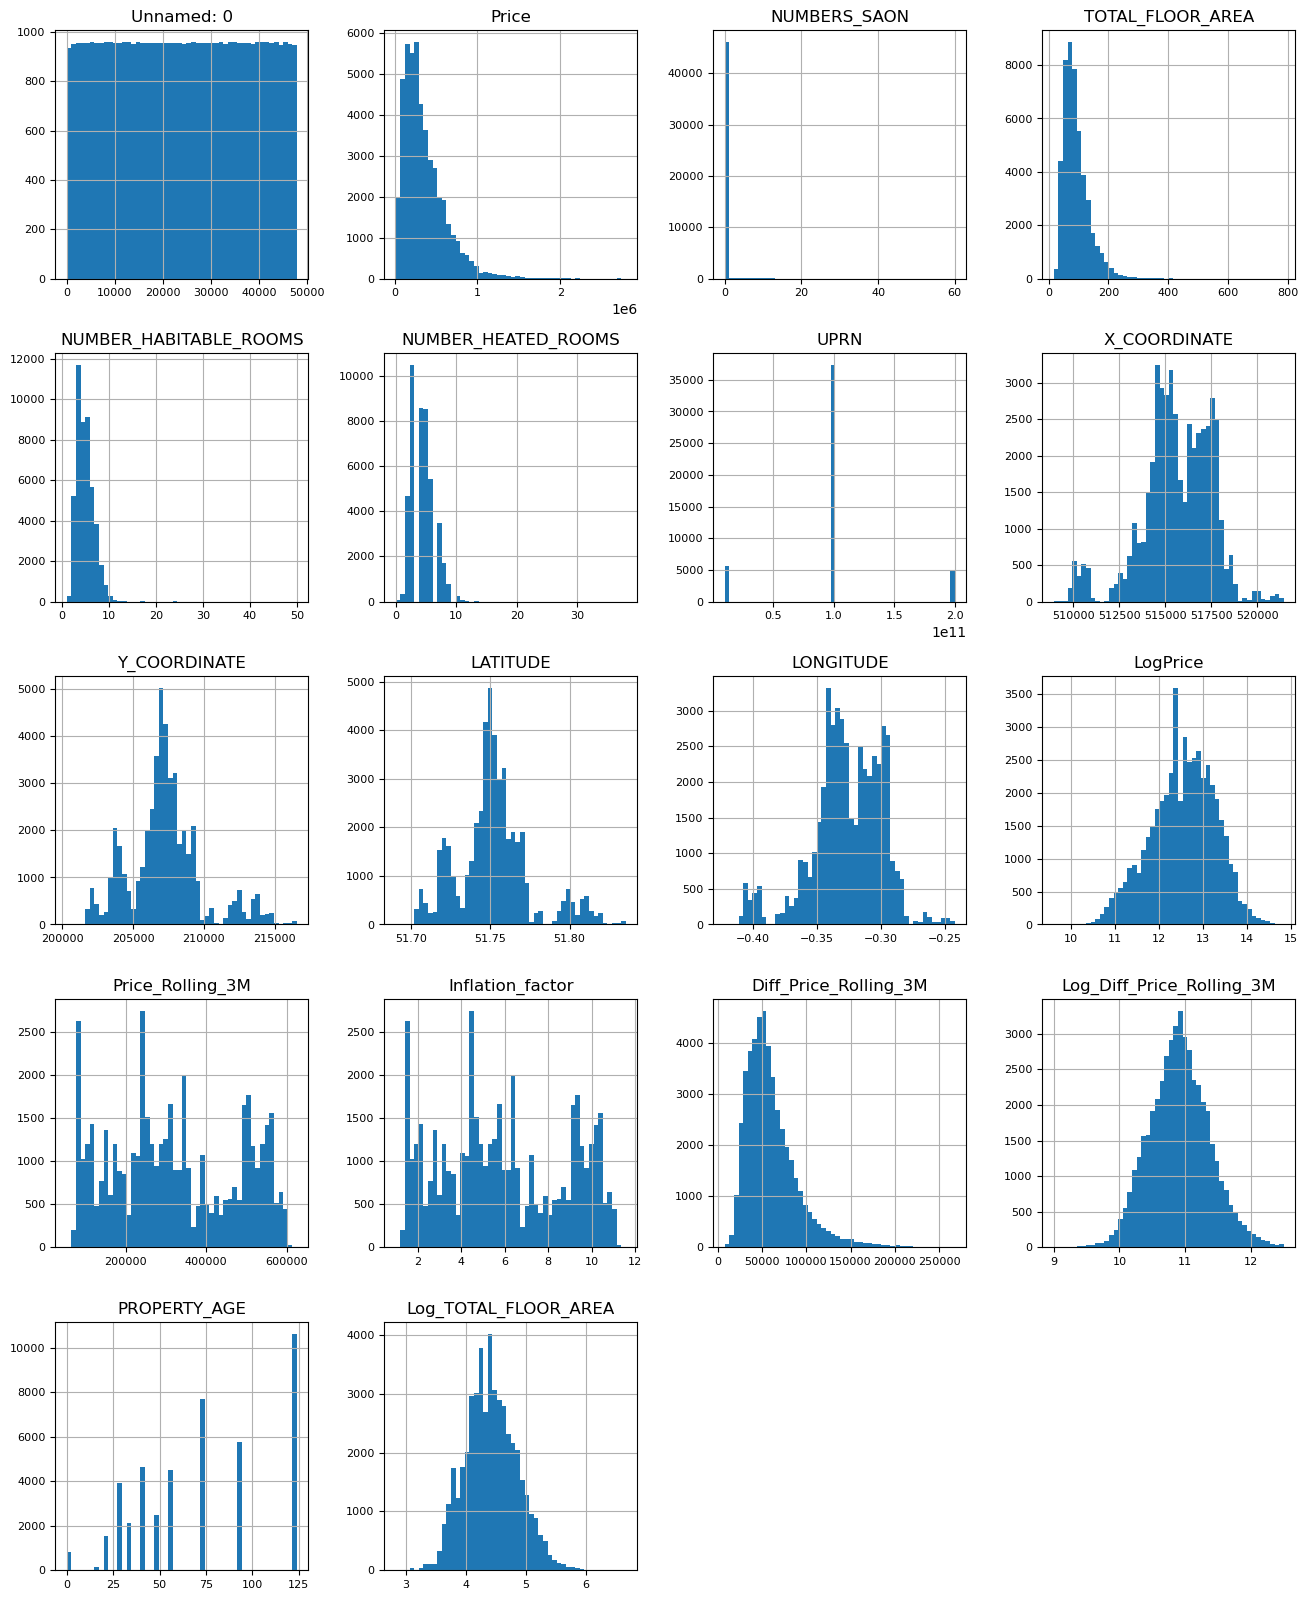

In [17]:

df_num = df_filtered.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);


The only other numerical features we can consider are the number of habitable rooms (or heated rooms). We will consider these (and others) later in the notebook. 

# Building the Linear Regression model 

To simplify the model, we are only going to consider houses, not flats. This could, of course, be extended to all property types, but as we show in the plot below, the distribution of prices for flats is much wider than for houses. Note, the houses are  further classified in the Land Registry dataset as Detached, Terrace or Semi-Detached. To ensure we are definitely looking at houses, we only consider those properties which are houses in both the EPC and Land Registry dataset.

<Axes: xlabel='Log_TOTAL_FLOOR_AREA', ylabel='Log_Diff_Price_Rolling_3M'>

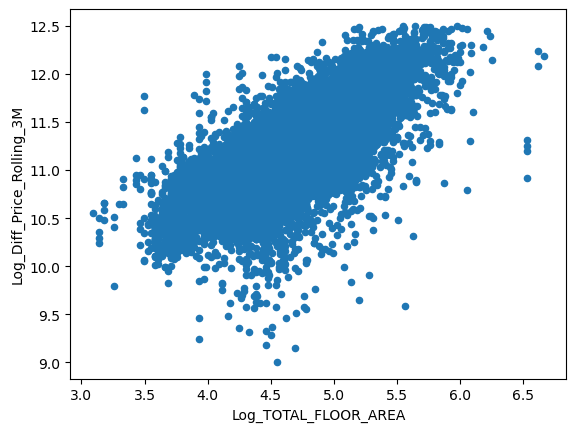

In [18]:
#Let's only consider houses

house_df = df_filtered.loc[(df_filtered['PROPERTY_TYPE'] == 'House') 
               & ((df_filtered['property type'] == 'D' ) | 
                (df_filtered['property type'] == 'S')  |
                (df_filtered['property type'] == 'T')) & 
                 (df_filtered['PPDCategory Type'] == 'A')]

# we can plot our new log inflation adjusted sold price against the log of the total floor area 
# and examine whether it is suitable for linear regression. 

df_filtered.loc[(df_filtered['PROPERTY_TYPE'] == 'House') 
               & ((df_filtered['property type'] == 'D' ) | 
                (df_filtered['property type'] == 'S')  |
                (df_filtered['property type'] == 'T')) & 
                 (df_filtered['PPDCategory Type'] == 'A')].plot(x='Log_TOTAL_FLOOR_AREA', y='Log_Diff_Price_Rolling_3M', kind='scatter')


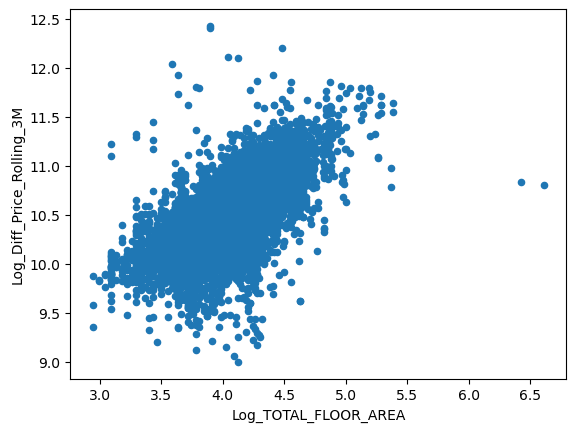

<Figure size 640x480 with 0 Axes>

In [19]:
# lets also look at flats - more outliers
df_filtered.loc[(df_filtered['PROPERTY_TYPE'] == 'Flat')].plot(x='Log_TOTAL_FLOOR_AREA', y='Log_Diff_Price_Rolling_3M', kind='scatter')
plt.show()
plt.clf()

It looks like a linear relationship - let's build a linear regression model, and check the r2 score. 

In [20]:
#IMPORT ALL THE MACHINE LEARNING LIBRARIES HERE: 

import numpy as np
import itertools
import matplotlib.pyplot as plt
import sklearn 
#prep

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MaxAbsScaler, QuantileTransformer

#models
from sklearn.linear_model import  LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#validation libraries
#from sklearn.cross_validation import KFold, StratifiedKFold
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import  r2_score, mean_squared_error

# map plotting libraries 
import folium 
import geopandas as gpd
import geojson as geojson
import branca.colormap as cm
from branca.colormap import linear

training and validation size: (25104, 1) (6277, 1) (25104, 1) (6277, 1)


/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_46235/1547795972.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df.loc[:, 'linear_fit']=lm.predict(X.values)
/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_46235/1547795972.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_df.loc[:, 'diff_in_prediction'] = house_df['Log_Diff_Price_Rolling_3M'] - house_df['linear_fit']


R² Score for linear regression: 0.11953407420266271
mean_squared_error for linear regression: 0.06890932424694578


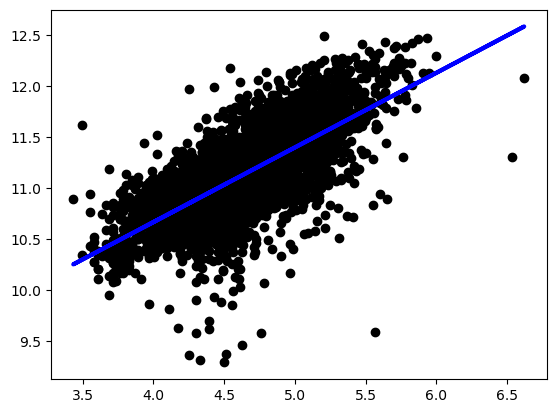

<Figure size 640x480 with 0 Axes>

In [21]:
X = house_df[['Log_TOTAL_FLOOR_AREA']]
y = house_df[['Log_Diff_Price_Rolling_3M']]

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2)
print("training and validation size:", X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
lm = LinearRegression()
lm.fit(X_train.values,y_train)

# Let's check 

house_df.loc[:, 'linear_fit']=lm.predict(X.values)
house_df.loc[:, 'diff_in_prediction'] = house_df['Log_Diff_Price_Rolling_3M'] - house_df['linear_fit']

house_df.plot(x='Price',y='diff_in_prediction', kind='scatter')
y_pred_test = lm.predict(X_valid.values)
r2_lm = r2_score(y_pred_test,y_valid)
mse_lm = mean_squared_error(y_pred_test,y_valid)
print(f"R² Score for linear regression: {r2_lm}")
print(f"mean_squared_error for linear regression: {mse_lm}")
plt.clf()
plt.scatter(X_valid, y_valid, color="black")
plt.plot(X_valid, y_pred_test, color="blue", linewidth=3)

plt.show()
plt.clf()

We get a r2 value of approximately 0.15, which indicates the large residuals, although we can visualise an approximate linear relationship. We have added the residuals as the "diff_in_prediction" column in the house_df dataframe.

# Geospatial distribution of a property's *added-value* (i.e. residual)

We now have our linear regression model relating the (log) total floor area to the (log) inflation adjusted sold price. 

We have created a new column, called "diff_in_prediction". This is the residual for the linear regression.

Let's consider what this represents: A high "diff_in_prediction" means the property sold for more than you would expect for that floor area in the St Albans district. It can be viewed as the "*added value*" of a property. This could be related to the location, type of house, condition of the house etc. In the following, we will consider how the added value is related to the property's location in St Albans.

We consider the geospatial distribution of these residuals for the linear regression model.

We will use geojson and folium to plot the distribution on a map. We'll group together by partial postcodes (called sectors) and finally by full postcodes (called units). 

To do so, we use geojson polygons for each postcode and sector from Map-It “Powered by MapIt”: https://postcodes.mapit.longair.net/

The polygons were downloaded locally, but this procedure could be used for any district / area as long as you are prepared to download them. 

We'll first look at the geospatial distribution at the sector level of the postcode, which is the first 4 characters of the AL postcode (not including spaces), such as AL1 1. 

We'll then look at the full 6 character postcode, called "units" - but as there are many of these, we'll focus only on the AL1 district. 

In [22]:
geo_files = []

postcodes = house_df['POSTCODE'].unique()

# first lets group by the first 5 characters of the postcode, which includes a blank space. "AL1 1" for example. 

unique = list(set([x[:5] for x in postcodes if x[:2] == 'AL']  ))

post_code_to_price = {post_code: house_df.loc[house_df['POSTCODE'].str.startswith(post_code)]['diff_in_prediction'].median() for post_code in unique}

base_string = "../gb-postcodes-v5/sectors/"
geo_postcodes = []

map_hooray = folium.Map(location=[51.74450347,-0.32857588],zoom_start= 11) # coordinates of the centre of St Albans

post_list = list(post_code_to_price.values())
mean_post_code =  np.array(post_list).mean()
std_dev_post_code = np.array(post_list).std()

#colormap = linear.YlOrRd_09.scale(mean_post_code-std_dev_post_code, mean_post_code+std_dev_post_code) # alternative colourmap
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=mean_post_code-std_dev_post_code, vmax = mean_post_code+std_dev_post_code)

color_list = []
for first_postcode in unique: 
    file = base_string + str(first_postcode[:3]) + "/" + first_postcode + ".geojson"
    geo_1 = gpd.read_file(file)
    color_list.append(colormap(post_code_to_price[first_postcode]))
    geo_postcodes.append(geo_1)
    
geoframe = pd.concat(geo_postcodes, axis=0, ignore_index=True)
for i, x in enumerate(geoframe.index):
    geoframe.at[x, 'color'] = color_list[i]

def style(feature):
        return {
            'fillColor': feature['properties']['color'],
            'color': feature['properties']['color'],
            'weight': 1
        }

folium.GeoJson(data=geoframe, style_function=style).add_to(map_hooray)
map_hooray

This is getting interesting - as we can see, the highest *added value* (residuals) are in the centre of St Albans (the red colours). 

However, the sector level doesn't give us enough granuality to spot any clusters of higher-, or lower-valued properties. 

Let's instead use a grid approach and examine the average residuals within that grid. 

In [23]:

m = folium.Map(location=[51.74450347,-0.32857588], zoom_start=13)

#Define grid parameters
min_lat, max_lat = house_df['LATITUDE'].min(), house_df['LATITUDE'].max()  # Latitude range
min_lon, max_lon = house_df['LONGITUDE'].min(), house_df['LONGITUDE'].max()  # Longitude range

# Number of rectangles in the grid, change for more / less detail
num_rows = 50 
num_cols = 50 

lat_step = (max_lat - min_lat) / num_rows
lon_step = (max_lon - min_lon) / num_cols

avg_prices = np.zeros((num_rows, num_cols))
list_average = []
# Loop through the grid, calculate average prices (median) for each rectangle
for i in range(num_rows):
    for j in range(num_cols):
        # Define the corners of the rectangle (grid cell)
        lat_min = min_lat + i * lat_step
        lat_max = min_lat + (i + 1) * lat_step
        lon_min = min_lon + j * lon_step
        lon_max = min_lon + (j + 1) * lon_step
        
        # Filter rows that fall within the current grid cell (rectangle)
        mask = (
            (house_df['LATITUDE'] >= lat_min) &
            (house_df['LATITUDE'] < lat_max) &
            (house_df['LONGITUDE'] >= lon_min) &
            (house_df['LONGITUDE'] < lon_max)
        )
        
        # Compute the average price for the rows within this grid cell
        if mask.any():
            avg_price = house_df.loc[mask, 'diff_in_prediction'].median()
            list_average.append(avg_price)
        else:
            avg_price = -10000  # Assign 0 if no properties are in the grid cell
        
        avg_prices[i, j] = avg_price
        
list_average = np.asarray(list_average)

#Create a color map for the prices

colormap = linear.YlOrRd_09.scale(list_average.mean()-2*list_average.std(), list_average.mean()+2*list_average.std())
#colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=list_average.mean()-list_average.std(), vmax = list_average.mean()+list_average.std())

# Add rectangles to the Folium map with colors based on average prices
for i in range(num_rows):
    for j in range(num_cols):
        # Get the corners of the rectangle
        bottom_left = [min_lat + i * lat_step, min_lon + j * lon_step]
        top_right = [min_lat + (i + 1) * lat_step, min_lon + (j + 1) * lon_step]
        
        # Get the average price and map it to a color
        avg_price = avg_prices[i, j]
        color = colormap(avg_price) if avg_price > -10000 else "#FFFFFF"  # White if no price data
        
        # Create the rectangle and add it to the map
        folium.Rectangle(
            bounds=[bottom_left, top_right],
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.6
        ).add_to(m)


colormap.add_to(m)

m


Now this is getting really interesting. We can see where the highest valued properties (relative to their square footage) are: primarily in the north-east of the centre of St Albans, with some outling regions as well. Lower values properties are in the south-east of the town and further out. 

Grid representations, although useful and computational efficient, are not natural divisions of properties. There are not reflective of housing densities. So, instead, we'll examine the distribution as a function of the individual postcodes, which are on average 15 properties on the same street or local region. We'll concentrate on the AL1 postcodes, again using geojson polygons for postcodes from Map-it. Note, I've only downloaded the AL1 postcode geojson polygons, but the cell below will work if you have more geojson polygon areas. 

We'll plot each postcode geojson polygon coloured by the average *added-value* in that unit postcode. 


In [24]:
import os 

geo_files = []

unique = list(set([x for x in postcodes if x[:2] == 'AL']  ))

# compute median diff_in_prediction for all postcodes
post_code_to_price = {post_code: house_df.loc[house_df['POSTCODE'].str.startswith(post_code)]['diff_in_prediction'].median() for post_code in unique}

base_string = "../St_Albans_postcode_geojson/geojson/"

geo_postcodes = []

#initialise folim map located on the centre of St Albans. 
map_AL1 = folium.Map(location=[51.74450347,-0.32857588],zoom_start= 14)

# we'll rescale the diff_in_prediction values so they are comparable to the geospatial variables.  
post_list = list(post_code_to_price.values())
min_post_code, max_post_code  = np.array(post_list).min(), np.array(post_list).max()
mean_post_code, std_dev_post_code  =  np.array(post_list).mean(), np.array(post_list).std()

#Create a color map for the diff_in_prediction
#colormap = linear.YlOrRd_09.scale(mean_post_code-2*std_dev_post_code, mean_post_code+2*std_dev_post_code) # alternative colormap
colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=mean_post_code-2.0*std_dev_post_code, vmax = mean_post_code+2.0*std_dev_post_code)

color_list = []
not_in = []
centroid_list = []
for first_postcode in unique: 
    
    file = base_string + first_postcode + ".json"
    if os.path.isfile(file):
       
       geo_1 = gpd.read_file(file) # read in each geojson polygon for each postcode 
       geometry = geo_1.to_crs('+proj=cea').centroid.to_crs(geo_1.crs) # get centroid for each postcode

       area = geo_1.to_crs('+proj=cea').area

       # create a list containing information about postcodes
       # scale all average diff_in_predictions to be between 0 - 1
       centroid_list.append([first_postcode, area[0],
                             geometry.x[0], geometry.y[0],
                             (post_code_to_price[first_postcode]-min_post_code)/(max_post_code - min_post_code)]) 
       geo_postcodes.append(geo_1)
       color_list.append(colormap(post_code_to_price[first_postcode])) 
    else: 
       not_in.append(first_postcode)

gdf = pd.DataFrame(centroid_list, columns=['POSTCODE', 'AREA', 'LONGITUDE', 'LATITUDE', 'DIFF_IN_PREDICTION'])
min_lat, max_lat = gdf['LATITUDE'].min(), gdf['LATITUDE'].max()  # Latitude range
min_lon, max_lon = gdf['LONGITUDE'].min(), gdf['LONGITUDE'].max()  # Longitude range

gdf['DIFF_IN_PREDICTION'] = gdf['DIFF_IN_PREDICTION'] *(3.0*((max_lat - min_lat) + (max_lon - min_lon))) 
# a factor of three compared to the geospatial distributions seems to create reasonable clustering

geoframe = pd.concat(geo_postcodes, axis=0, ignore_index=True)
for i, x in enumerate(geoframe.index):
    geoframe.at[x, 'color'] = color_list[i] # add colour for each geojson polygon according to average diff_in_prediction
   
folium.GeoJson(data=geoframe, style_function=style).add_to(map_AL1)

# display map with shaded polygons
map_AL1

Note, as said above, this is not all postcodes for the whole AL area, but all of AL1 postcodes (plus a few neighbouring ones). 

This is really interesting - we can see definite clusters of house price value. Remember, this isn't house price. I've called this house *added-value*, because in effect it is showing where houses cost more per square foot than the rest of the St Albans district. 

We see clusters of high value in the north east, cheaper areas in the south west and south east. 

Let's see if we can use cluster methods (DBSCAN) to formally cluster these postcodes / properties. 

# Cluster analysis

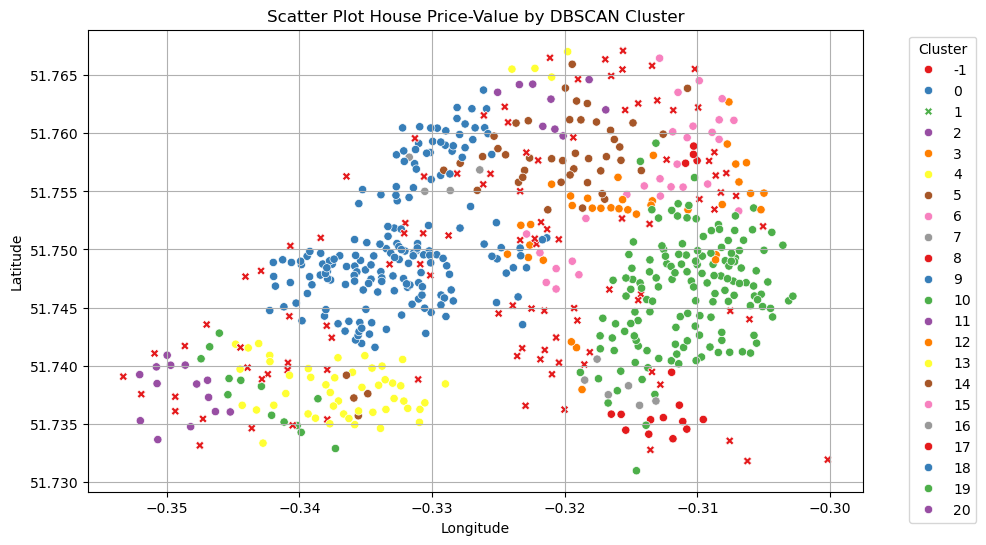

<Figure size 640x480 with 0 Axes>

In [25]:
from sklearn.cluster import DBSCAN

# in the previous cell, we created a three dimensional array of longitude, latitude and diff_in_prediction for each postcode.
# diff_in_price is scaled to be comparable to the actual distances.
# We've used the centroid of the polygon as the postcode coordinates. 

# Set DBSCAN parameters 
eps_value = 0.0045  # Note these values have to be varied to find a optimal parameters.
min_samples_value = 3

# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value, metric='euclidean')
gdf['cluster'] = dbscan.fit_predict(gdf[['LONGITUDE','LATITUDE','DIFF_IN_PREDICTION']])

# we'll remove clusters with less than 3 postcodes, to limit the number of clusters to something (relatively) small

counts = gdf['cluster'].value_counts()
idx = counts[counts.lt(3)].index  
gdf.loc[gdf['cluster'].isin(idx), 'cluster'] = -1  # cluster number -1 means unassigned to a cluster
counts = gdf['cluster'].value_counts()
# plot the clusters:

#import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot noise points (-1 cluster)
sns.scatterplot(
    x=gdf['LONGITUDE'],
    y=gdf['LATITUDE'],
    hue=gdf['cluster'],  # Color by cluster
    palette='Set1',  
    style=gdf['cluster'] == -1,  # Different marker style for noise, set unallocated to -1
    markers={True: 'X', False: 'o'},  # Noise as 'x', clusters as 'o'
    #size=gdf['PRICE'],  # Optional: size points by price
  
    legend='full'
)

# Plot polygon centroids with cluster labels
plt.title("Scatter Plot House Price-Value by DBSCAN Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.show()
plt.clf()



# Lets add together the geojson polygons to form polygons for the clusters, and plot them on a folium map. 

DBSCAN has clustered the houses into groups based on their location and price. We'll add the geojson polygons in a cluster together to form larger areas - I'm going to term them *added-value regions* - and then plot them on a folium map.

In [26]:

#print(gdf['cluster'].value_counts())
from shapely.ops import unary_union

# Initialize an empty dictionary to store merged polygons by cluster
merged_polygons = {}

# calculate the average diff_in_prediction over each region for shaping the merged polygons.  
avg_diff = gdf.groupby('cluster')['DIFF_IN_PREDICTION'].mean().to_dict()
full_avg_diff = np.array(list(avg_diff.values())).mean()
#print("FULL AVG", full_avg_diff)
full_avg_std = np.array(list(avg_diff.values())).std()
# Loop through each GeoJSON file and the corresponding cluster in gdf
for geo_df2, cluster in zip(geo_postcodes, gdf['cluster']):

    if cluster > -1: # not unallocated postcodes. 
   
        geo_df2['cluster'] = cluster
    
    # If the cluster already exists in merged_polygons, append the geometries
        if cluster in merged_polygons:
           merged_polygons[cluster].append(geo_df2.geometry)
        else:
           merged_polygons[cluster] = [geo_df2.geometry]

colormap = cm.LinearColormap(["blue", "green", "yellow", "red"], vmin=full_avg_diff-1.0*full_avg_diff, vmax = full_avg_diff-1.0*full_avg_diff) 

#print(gdf['cluster'].value_counts())

final_polygons = []
colour_list = []

for cluster, geometries in merged_polygons.items():
    # Merge the geometries of the same cluster into a single polygon 
    merged_geometry = unary_union(geometries)
    final_polygons.append({'cluster': cluster, 'geometry': merged_geometry})
    color_list.append(colormap(avg_diff[cluster])) 
    
# Convert the results into a new GeoDataFrame - 
# final_gdf is the GeoDataFrame containing the merged polygons by cluster

final_gdf = gpd.GeoDataFrame(final_polygons)

# Needed for follium plot, otherwise it complains about missing CRS
if final_gdf.crs is None:  
    final_gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
else:
    final_gdf = final_gdf.to_crs("EPSG:4326")

# add colours depending on average diff_in_prediction
for i, x in enumerate(final_gdf.index):
    final_gdf.at[x, 'color'] = color_list[i]


m = folium.Map(location=[51.74450347,-0.32857588],zoom_start= 14) #folium.Map(location=map_center, zoom_start=10)

folium.GeoJson(data=final_gdf, style_function=style).add_to(m)

# display map

m



This is very interesting - DBSCAN has created 20 clusters (although some postcodes are unassigned to a cluster). 

In [27]:
gdf['cluster'].value_counts()/len(gdf['cluster'])
print(gdf['cluster'].value_counts())

cluster
 0     169
 1     143
-1     106
 4      47
 5      42
 3      33
 6      20
 10     13
 8      12
 11     11
 2       9
 15      8
 7       6
 17      4
 18      4
 14      4
 13      4
 16      4
 9       3
 12      3
 19      3
 20      3
Name: count, dtype: int64


We have 20 added-value regions in total, with 16% of the postcodes unallocated (labelled as -1)

Let's see if we can find any correlations between the *added-value* regions (i.e. clusters) and the average features of the houses within the *added-value* region.

# Examining correlations between cluster properties

To examine the correlation of cluster averaged properties, we will need to do encoding on the type of house (Detached, Terrace or Semi-detached)

In [28]:
house_df_encoded_1 = pd.get_dummies(house_df, columns=['property type'], dtype=int) 

house_df_encoded = house_df_encoded_1.merge(gdf[['POSTCODE', 'cluster', 'AREA']], on='POSTCODE', how='left')

In [29]:
# create new dataframe of houses averaged over cluster

cluster_order = house_df_encoded.groupby('cluster')['diff_in_prediction'].median().sort_values(ascending=False)

# Create a mapping from the original cluster to the new ordered values
cluster_mapping = {cluster: rank for rank, cluster in enumerate(cluster_order.index)}

# Map the cluster column to the new ordered values
house_df_encoded['cluster'] = house_df_encoded['cluster'].map(cluster_mapping)

#any values which are undefined or NaN, convert to -1, the value for unallocated postcodes. 

house_df_encoded['cluster'] = house_df_encoded['cluster'].fillna(-1)

# make sure its the cluster variabe in an int, not a float
house_df_encoded['cluster'] = house_df_encoded['cluster'].astype(int)

aggregated_stats = house_df_encoded.groupby('cluster').agg(
    price_median=('Price', 'median'),

    #price_std=('Price', 'std'),
    floor_area_median=('TOTAL_FLOOR_AREA', 'median'),
    #floor_area_std=('TOTAL_FLOOR_AREA', 'std'),
    num_rooms_median=('NUMBER_HABITABLE_ROOMS', 'median'),
    #num_rooms_std=('NUMBER_HABITABLE_ROOMS', 'std'),
    num_type_D=('property type_D', 'mean'),
    num_type_T=('property type_T', 'mean'),
    num_type_S=('property type_S', 'mean'),
    residual_median=('diff_in_prediction', 'median'),
    age_median=('PROPERTY_AGE', 'median'),
    area_median=('AREA', 'median'),
    #residual_std=('diff_in_prediction', 'std')
    number_of_properties=('Price', 'count')
).reset_index()

# drop the unallocated clusters to perform the correlation analysis
aggregated_stats = aggregated_stats.loc[aggregated_stats['cluster'] > -1]

#print(aggregated_stats)
gdf_merged = pd.merge(gdf, aggregated_stats, on='cluster', how='left')

corr_matrix = aggregated_stats.corr(numeric_only=True)['residual_median']
print(corr_matrix)

cluster                -0.968412
price_median            0.774771
floor_area_median       0.672705
num_rooms_median        0.753578
num_type_D              0.723644
num_type_T             -0.690384
num_type_S              0.050874
residual_median         1.000000
age_median              0.482936
area_median            -0.126357
number_of_properties    0.034854
Name: residual_median, dtype: float64


We find the regions with high value (again, that is price above that expected for its total floor area), are of higher price, a higher number of rooms (and floor area, which is highly correlated with number of rooms), are detached, often older properties. Those with lower value are often terrace houses, while being semi-detached is not correlated with added-value. 

Let's create a random forest regression, and use feature extraction to see which properties are the most important. 

As this is Random Forest, there is no need to standard scale all features. 

In [30]:
feature_columns = ['floor_area_median', 'num_rooms_median', 'age_median', 'num_type_D', 'num_type_T', 'num_type_S']

X = aggregated_stats[feature_columns]
y = aggregated_stats['residual_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model 
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2:.2f}")
feature_importances = rf_model.feature_importances_
for feature, importance in sorted(zip(feature_columns, feature_importances)): 
    print(f"FOR FEATURE: {feature} IMPORTANCE IS: {importance:.2f}")


R2 score: 0.22
FOR FEATURE: age_median IMPORTANCE IS: 0.13
FOR FEATURE: floor_area_median IMPORTANCE IS: 0.13
FOR FEATURE: num_rooms_median IMPORTANCE IS: 0.26
FOR FEATURE: num_type_D IMPORTANCE IS: 0.24
FOR FEATURE: num_type_S IMPORTANCE IS: 0.08
FOR FEATURE: num_type_T IMPORTANCE IS: 0.15


Using just the average features of the merged postcode regions is not a good predictor of the average added-value (r2 score of just 33%).

However, in terms of feature importance, the average number of habitable rooms in the house and the amount of detached home in the merged region are the most important in adding value to the houses.  


# Using our clusters (regions) as a variable in predicting house prices: Random Forest Regression 

If we want to perform Random Forest Regression on all houses using the cluster (regions) variable as a feature, we need to be careful. 

The cluster variable is currently ordinal encoded, where  a unique integer is assigned to each region. This can be used in Random Forest Regression. The labels are ordered such that those with a high "diff_in_prediction" (added value) average have a lower cluster number. 

The problem is that Random Forest Regression will consider this as continous variable, so we may need to look at other ways of encoding the region. 

However, before we do that, we need to ensure all values are valid, including allocating postcodes which were not allocated to clusters. 

To do so, we will use k-means clustering to match unalloacted postcodes (in the AL1 postcode sector) to their nearest allocated neighbours. 


In [31]:
# use k-means clustering to allocate postcodes to their nearest neighbours based only on their coordinates. 

from sklearn.neighbors import KNeighborsClassifier

# Separate allocated and unallocated points

allocated_df = gdf[gdf['cluster'] != -1]
unallocated_df = gdf[gdf['cluster'] == -1]

# Define features for KNN (e.g., latitude and longitude)
X_allocated = allocated_df[['LATITUDE', 'LONGITUDE']]
y_allocated = allocated_df['cluster']

X_unallocated = unallocated_df[['LATITUDE', 'LONGITUDE']]

# Set up and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors
knn.fit(X_allocated, y_allocated)

# Predict clusters for unallocated points
unallocated_df['cluster'] = knn.predict(X_unallocated)

# Combine the allocated and newly assigned unallocated data
gdf_allocated = pd.concat([allocated_df, unallocated_df]).sort_index()

# Display the first few rows to confirm the change
#print(gdf_allocated.head())

#rint(gdf_allocated['cluster'].value_counts())

# We need to convert these into the ordered cluster list using the cluster_order dict
print(gdf['cluster'].value_counts())
print(gdf_allocated['cluster'].value_counts())
gdf_allocated['cluster'] = gdf_allocated['cluster'].map(cluster_mapping)


merged_df_encoded = house_df_encoded.merge(gdf_allocated[['POSTCODE', 'cluster']], on='POSTCODE', how='left', suffixes=('', '_gdf'))

# Update the 'cluster' in house_df_encoded with values from gdf_encoded
house_df_encoded['cluster'] = merged_df_encoded['cluster_gdf']



cluster
 0     169
 1     143
-1     106
 4      47
 5      42
 3      33
 6      20
 10     13
 8      12
 11     11
 2       9
 15      8
 7       6
 17      4
 18      4
 14      4
 13      4
 16      4
 9       3
 12      3
 19      3
 20      3
Name: count, dtype: int64
cluster
0     194
1     160
4      57
5      55
3      40
6      25
11     18
10     15
8      15
2      11
15     10
7       8
9       7
17      6
12      6
13      5
14      4
18      4
16      4
20      4
19      3
Name: count, dtype: int64


/var/folders/73/04s61fhs2l17cmr472j9zg_m0000gn/T/ipykernel_46235/535331824.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unallocated_df['cluster'] = knn.predict(X_unallocated)


We now have an *added-value* region associated with each property in the AL1 sector (called 'cluster').

We have labelled the *added-value* region according to its rank in a sorted list of *added-value*. 

For houses in these regions, we can compare a random forest prediction using the *added-value* region and without. 

Firstly, we'll benchmark our prediction without the *added-value* label as a feature. Our target variable will be the inflation adjusted Price. We'll use the other features we also have: the total floor area, number of habitable rooms, the property age and the type of house (which have been one-shot encoded). 

In [32]:
feature_columns = ['Log_TOTAL_FLOOR_AREA', 'PROPERTY_AGE', 'NUMBER_HABITABLE_ROOMS', 'property type_D', 'property type_S', 'property type_T']

filtered_house_df_encoded1 = house_df_encoded[house_df_encoded['POSTCODE'].str.startswith('AL1')]
filtered_house_df_encoded = filtered_house_df_encoded1[filtered_house_df_encoded1['cluster'] != -1] # incase any unallocated houses remain
filtered_house_df_encoded.dropna(subset = feature_columns, axis=0, inplace=True) # again, in case any NaNs remain, drop them

# Prepare features and target variable - inflation adjusted price 
X = filtered_house_df_encoded[feature_columns]
y = filtered_house_df_encoded['Diff_Price_Rolling_3M']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)

mse_no_region = mean_squared_error(y_test, y_pred)
r2_no_region = r2_score(y_test, y_pred)

print(f"R2 without including regions is: {r2_no_region:.2f}")
feature_importances_no_region = rf_model.feature_importances_
for feature, importance in sorted(zip(feature_columns, feature_importances_no_region)): 
    print(f"FOR FEATURE: {feature} IMPORTANCE WITHOUT INCLUDING REGIONS IS: {importance:.2f}")

# uncomment if you want to do hyperparameter tuning

#from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid with ranges
#param_dist = {
#    'n_estimators': np.arange(50, 200, 50),
#    'max_depth': [20, 30, 30, 40],
#    'min_samples_split': np.arange(2, 10, 2)
#}

# Initialize RandomizedSearchCV
#random_search = RandomizedSearchCV(
 #   estimator=RandomForestRegressor(random_state=42),
 #   param_distributions=param_dist,
 #   n_iter=30,  # Number of random combinations to try
 #   cv=5,
#    scoring='r2',
 #   n_jobs=-1,
#    random_state=42
#)

# Fit random search
#random_search.fit(X, y)
#print(f"Best Parameters: {random_search.best_params_}")
#print(f"Best R^2 Score: {random_search.best_score_:.2f}")

R2 without including regions is: 0.74
FOR FEATURE: Log_TOTAL_FLOOR_AREA IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.79
FOR FEATURE: NUMBER_HABITABLE_ROOMS IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.05
FOR FEATURE: PROPERTY_AGE IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.06
FOR FEATURE: property type_D IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.09
FOR FEATURE: property type_S IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.00
FOR FEATURE: property type_T IMPORTANCE WITHOUT INCLUDING REGIONS IS: 0.00


In [33]:
feature_columns = ['Log_TOTAL_FLOOR_AREA', 'cluster', 'PROPERTY_AGE', 'NUMBER_HABITABLE_ROOMS', 'property type_D', 'property type_S', 'property type_T']

#filtered_house_df_encoded1 = house_df_encoded[house_df_encoded['POSTCODE'].str.startswith('AL1')]
#filtered_house_df_encoded = filtered_house_df_encoded1[filtered_house_df_encoded1['cluster'] != -1] # incase any unallocated houses remain
#filtered_house_df_encoded.dropna(subset = feature_columns, axis=0, inplace=True) # again, in case any NaNs remain, drop them

# Prepare features and target variable - inflation adjusted price 
X = filtered_house_df_encoded[feature_columns]
y = filtered_house_df_encoded['Diff_Price_Rolling_3M']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)

mse_with_region = mean_squared_error(y_test, y_pred)
r2_with_region = r2_score(y_test, y_pred)

print(f"R2 with added-value regions: {r2_with_region:.2f} compared to {r2_no_region:.2f} without.")
feature_importances_with_region = rf_model.feature_importances_
for feature, importance in sorted(zip(feature_columns, feature_importances_with_region)): 
    print(f"FOR FEATURE: {feature} IMPORTANCE INCLUDING REGIONS IS: {importance:.2f}")


# uncomment if you want to do hyperparameter tuning, can be quite slow, and I didn't notice much difference

#from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid with ranges
#param_dist = {
#    'n_estimators': np.arange(50, 200, 50),
#    'max_depth': [20, 30, 30, 40],
#    'min_samples_split': np.arange(2, 10, 2)
#}

# Initialize RandomizedSearchCV
#random_search = RandomizedSearchCV(
 #   estimator=RandomForestRegressor(random_state=42),
 #   param_distributions=param_dist,
 #   n_iter=30,  # Number of random combinations to try
 #   cv=5,
#    scoring='r2',
 #   n_jobs=-1,
#    random_state=42
#)

# Fit random search
#random_search.fit(X, y)
#print(f"Best Parameters: {random_search.best_params_}")
#print(f"Best R^2 Score: {random_search.best_score_:.2f}")

R2 with added-value regions: 0.80 compared to 0.74 without.
FOR FEATURE: Log_TOTAL_FLOOR_AREA IMPORTANCE INCLUDING REGIONS IS: 0.74
FOR FEATURE: NUMBER_HABITABLE_ROOMS IMPORTANCE INCLUDING REGIONS IS: 0.03
FOR FEATURE: PROPERTY_AGE IMPORTANCE INCLUDING REGIONS IS: 0.04
FOR FEATURE: cluster IMPORTANCE INCLUDING REGIONS IS: 0.11
FOR FEATURE: property type_D IMPORTANCE INCLUDING REGIONS IS: 0.08
FOR FEATURE: property type_S IMPORTANCE INCLUDING REGIONS IS: 0.00
FOR FEATURE: property type_T IMPORTANCE INCLUDING REGIONS IS: 0.01


We see that including the *added-value region* ('cluster') as a feature variable, we've improved our prediction of the inflation adjust price r2 score from 74% to 80%!

For features importance, we see a decrease in the total floor area, and cluster (i.e. *added-value region*) now contributes 12%. 


As a quick check, let's see what happens if we do one-shot encoding on the *added-value region*, compared to a integer label ('cluster'), which random forest regression will regard as a continous variable. This leads to 22(!) different features, corresponding to each of the added-value regions. 

In [34]:
import pandas as pd

# Perform one-hot encoding on the 'cluster' column
house_df_encoded = pd.get_dummies(filtered_house_df_encoded, columns=['cluster'], prefix='region', dtype=int)

# Display the first few rows of the new dataframe, see what is looks like now
print(house_df_encoded.head())


   Unnamed: 0         Transaction unique identifier  Price POSTCODE Old/New  \
0       28470  36CB8C09-BACD-4831-A741-D47D49F1CE70  62950  AL1 2QS       N   
1       18139  43874E75-CAD1-4967-85EE-253C5953E0D0  86100  AL1 5QA       N   
3       27449  FFFFE78F-50D6-47BD-999A-8EC8D448509C  59950  AL1 1PD       N   
4       20079  CEE11BF4-9A01-48EC-9628-59C1562A5F4E  77000  AL1 5NA       N   
7       31369  D9C9EBB4-A97A-4103-A1E7-B704727ECF57  76500  AL1 5NG       N   

  Duration SAON PAON           street   Locality,  ... region_12.0  \
0        F  NaN    4      MERCERS ROW  ST. ALBANS  ...           0   
1        F  NaN   24  ENNERDALE CLOSE  ST. ALBANS  ...           0   
3        F  NaN   38     WATSONS WALK  ST. ALBANS  ...           0   
4        F  NaN   27         ELY ROAD  ST. ALBANS  ...           0   
7        F  NaN   44     ROYSTON ROAD  ST. ALBANS  ...           0   

  region_13.0 region_14.0 region_15.0 region_16.0 region_17.0  region_18.0  \
0           0           1 

In [35]:
house_df_numeric = house_df_encoded.select_dtypes(include=['number'])
# drop all non-numeric columns

In [36]:
print(house_df_numeric.columns)

Index(['Unnamed: 0', 'Price', 'NUMBERS_SAON', 'TOTAL_FLOOR_AREA',
       'NUMBER_HABITABLE_ROOMS', 'NUMBER_HEATED_ROOMS', 'UPRN', 'X_COORDINATE',
       'Y_COORDINATE', 'LATITUDE', 'LONGITUDE', 'LogPrice', 'Price_Rolling_3M',
       'Inflation_factor', 'Diff_Price_Rolling_3M',
       'Log_Diff_Price_Rolling_3M', 'PROPERTY_AGE', 'Log_TOTAL_FLOOR_AREA',
       'linear_fit', 'diff_in_prediction', 'property type_D',
       'property type_S', 'property type_T', 'AREA', 'region_0.0',
       'region_1.0', 'region_2.0', 'region_3.0', 'region_4.0', 'region_5.0',
       'region_6.0', 'region_7.0', 'region_8.0', 'region_9.0', 'region_11.0',
       'region_12.0', 'region_13.0', 'region_14.0', 'region_15.0',
       'region_16.0', 'region_17.0', 'region_18.0', 'region_19.0',
       'region_20.0', 'region_21.0'],
      dtype='object')


In [37]:
y = house_df_numeric['Diff_Price_Rolling_3M']
X = house_df_numeric.drop(columns=['Unnamed: 0', 'Price', 'TOTAL_FLOOR_AREA', 'NUMBERS_SAON', 'NUMBER_HEATED_ROOMS', 'UPRN', 'X_COORDINATE',
       'Y_COORDINATE', 'LATITUDE', 'LONGITUDE', 'LogPrice', 'Price_Rolling_3M',
       'Inflation_factor', 'Price_Rolling_3M', 'Diff_Price_Rolling_3M',
       'Log_Diff_Price_Rolling_3M','linear_fit', 'diff_in_prediction', 'AREA']) 
# drop numeric columns not used as features
print(X.columns) 



Index(['NUMBER_HABITABLE_ROOMS', 'PROPERTY_AGE', 'Log_TOTAL_FLOOR_AREA',
       'property type_D', 'property type_S', 'property type_T', 'region_0.0',
       'region_1.0', 'region_2.0', 'region_3.0', 'region_4.0', 'region_5.0',
       'region_6.0', 'region_7.0', 'region_8.0', 'region_9.0', 'region_11.0',
       'region_12.0', 'region_13.0', 'region_14.0', 'region_15.0',
       'region_16.0', 'region_17.0', 'region_18.0', 'region_19.0',
       'region_20.0', 'region_21.0'],
      dtype='object')


In [38]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Initialize the model
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model1.fit(X_train1, y_train1)

RandomForestRegressor(random_state=42)

In [40]:
y_pred1 = rf_model1.predict(X_test1)

# Evaluate the model
mse = mean_squared_error(y_test1, y_pred1)
r2_with_one_hot = r2_score(y_test1, y_pred1)
print(f"Mean Squared Error: {mse}")
print(f"R2 without including regions is: {r2_with_one_hot:.2f}")

Mean Squared Error: 240963135.3652405
R2 without including regions is: 0.80


The R2 score is 0.80, the same as before with one 'cluster' feature. So one-shot encoding makes no difference to the accuracy of the predictions. 

# Let's try xgboost as a comparison, using the same training and validation data set as the Random Forest Regression. 

In [41]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Fit the model
xgb_model.fit(X_train1, y_train1)

y_pred_xgboost = xgb_model.predict(X_test1)

# Evaluate the model
mse = mean_squared_error(y_test1, y_pred_xgboost)
print(f"Mean Squared Error: {mse}")
r2_with_xgboost = r2_score(y_test1, y_pred_xgboost)
print(f"R2 without including regions is: {r2_with_xgboost:.2f}")

Mean Squared Error: 234962404.0029756
R2 without including regions is: 0.81


The R2 and mse values are comparable when using XGBOOST and RandomForestRegressor, although obviously no hyper parameter tuning has been done. 

Still, an r2 score of 0.8 is very good!